# Group 9 - Analysing the Results of Metaheuristics Tacking the TSP

* Olukayode Martins (marti196)
* Matthew Cheung (cheun227)
* Robert Green (greenr27)
* Humza Shahid (shahidh7)


[https://github.coventry.ac.uk/380CT-2021/Group-........](https://github.coventry.ac.uk/380CT-2021/Group-........)

# 1) Notation and definitions

Let $G$ be a [complete]( "graph is undirected, has no self-loops, and each node is connected to all the other vertices")  [weighted]( "the edges have a weight (a positive integer)") graph with $n$ vertices.

**Optimisation TSP**:
> Given $G$, find a cycle of minimal total cost.

This problem is **NP-Hard** because its decision version is **NP-complete** (Garey and Johnson, 1979, p. 211).

# 2) Testing methodology

```
.................................................................
.................................................................
...  You can add or improve this section and its subsections  ...
.................................................................
.................................................................
```

* **Exact method (Exhaustive search)**:
    Average _time_ for instances with increasing $n$.

* **Greedy and meta-heuristics**:
    Average _time_ and _"quality"_ as $n$ increases.

Instances will be generated randomly as shown in the next subsection.

## 2.1) Random instances sampling strategy

Four types of TSP instances will be generated by creating an **adjacency matrices** $M$ as follows:
1. **Asymmetric**: The edge weights are independent and uniformly random in an interval $[1,\text{MAX_WEIGHT}]$, i.e the graph is assumed to be directed.
2. **Symmetric**: Like the asymmetric case but the graph is undirected, and the matrix is therefore symmetric: $M_{ij}=M_{ji}$.
3. **Euclidean**: Generate points using $(x,y)$ coordinates, then generate the adjacency matrix by calculating all the required distances. Recall that the distance between two points $(x_1,y_1)$ and $(x_2,y_2)$ is $\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$. The points are generated in the rectangle defined by the points $(0,0)$ and $(\text{MAX_Y},\text{MAX_Y})$.
4. **Graphs with obvious shortest cycle**: A graph where all the distances are 2 except for the edges on a predefined cycle, where the distance is 1. Such a graph would be useful for testing/debugging the "nearest neighbour greedy" search.

### Implementation of the instances generation

First start by importing relevant libraries.

In [1]:
from random import randint, shuffle # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from itertools import chain # concatenate range()'s'
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
import copy # to copy an object so it can be modified while preserving the original
sns.set_style("white")
import numpy as np
import operator

from math import exp #returning exponentials (used for simulated annealing)
import random #getting probability (used for simulated annealing)

### Basics

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

For simplicity, we will consider $0$ to be the start and end point of cycles.

In [2]:
class Graph:
    ''' Random graphs '''
    def __init__(self, n=0, type='asymmetric', MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if   type=='symmetric': self.__random_symmetric_graph(n,MAX_WEIGHT)
        elif type=='Euclidean': self.__random_euclidean_graph(n,MAX_X,MAX_Y)
        elif type=='easy':      self.__random_cycle_graph(n)
        else:                   self.__random_asymmetric_graph(n,MAX_WEIGHT) # assume 'asymmetric' otherwise
            
    def __getitem__(self, i):
        ''' Allow indexing to get the weights '''
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self,n, MAX_WEIGHT):
        ''' Asymmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(n):
                if i==j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1,MAX_WEIGHT)

    def __random_symmetric_graph(self,n,MAX_WEIGHT):
        ''' Symmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(i+1,n):
                w = randint(1,MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        ''' Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) '''
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1,n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a,b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self,n,MAX_X,MAX_Y):
        ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points)<n: # We may get duplicate (x,y) so we try until we get enough points
            x,y = randint(0,MAX_X), randint(0,MAX_Y)
            points.add((x,y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1,n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points=points

In [3]:
def cost(G, cycle):
    ''' Calculate the cost of the given cycle [0,...,0] in G '''
    return sum(G[a][b] for a,b in zip(cycle, cycle[1:]))

Functions to show the graphs as **adjacency matrices** or as a **drawing**:

In [4]:
def show(G):
    ''' Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    '''
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type=='Euclidean': print("Points:",G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)
    
def nx_graph(G):
    ''' Convert G into NetworkX format '''
    nxG = nx.Graph() if G.type!='asymmetric' else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    for a in G.vertices:
        for b in G.vertices:
            if a==b: continue # no self-loops
            nxG.add_edge(a, b, weight=G[a][b])        
    if G.type=='Euclidean': # add (x,y) coordinates if available
        pos=dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, 'coord')
    return nxG

def draw(G):
    ''' Draw the graph G using NetworkX '''
    nxG = nx_graph(G)
    weights_dictionary = nx.get_edge_attributes(nxG,'weight')
    edges,weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type!='Euclidean' else nx.get_node_attributes(nxG,'coord')
    nx.draw(nxG, pos, \
            with_labels=True, node_color='red', font_color='white', font_weight='bold', font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3,rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary, label_pos=0.5 if G.type!="asymmetric" else 0.25)

## 3) Nearest Neigbour Greedy method

#### Idea

Start at city 0, move to the nearest city, then from there to the next nearest city, and so on, until all cities are visited. Finally, return back to the start city.

#### Pseudocode

1. $city \gets 0$
2. $visited\gets []$
3. **while** not all cities are visited **do**
4. $\quad$ $nearest\_city \gets \text{nearest city to $city$ that has not been visited yet}$
5. $\quad$ Append $city$ to $visited$ $\qquad\qquad\text{(i.e. mark $city$ as visited)}$
5. $\quad$ $city\gets nearest\_city$
6. **end while**
8. **return** $visited$

#### Running time analysis

The while-loop costs $O(n)$, and searching for the nearest city on line 4 costs $O(n)$ also, while the rest can be assumed to cost $O(1)$.
So the total cost of this greedy approach is therefore $O(n)\times O(n) = O(n^2)$.

#### Implementation

In [5]:
def greedy_nearest_neighbour(G):
    ''' Returns best found cycle and its cost '''
    unvisited = G.vertices.copy()
    visited = [] # solution to be built
    city = 0 # Start city
    while len(unvisited)>0:
        # Find nearest neighbour
        nearest_city = None
        shortest_distance = oo
        for neighbour in unvisited:
            if G[city][neighbour] < shortest_distance:
                shortest_distance = G[city][neighbour]
                nearest_city = neighbour
        # Update 'cycle' and 'cities' and G then 'city'
        visited.append(city)
        unvisited.remove(city)
        city = nearest_city
    return (visited, cost(G, visited+[0]))

#### Statistics for Nearest Neighbour Greedy Meethod

In [6]:
def greedy_stats(num_vertices, num_tests, graph_type='asymmetric'):
    '''Perform greedy search on graphs with a given number over vertices, a given number of times,
    and return (a) list of time elapsed and (b) list of cost reductions in %'''
    
    # Initialise lists for calculating mean
    time_list = []
    cost_list = []
    
    # Loop that:
    # 1. Generates a graph of input type with input number of vertices
    # 2. Records cost of start cycle, and the current time before SA is performed
    # 3. Performs Greedy Nearest Neighbour search
    # 4. Records current time after search performed
    # 5. Calculates elapsed time and difference in cost, and append these values to list
    for loop in range(num_tests):
        G = Graph(num_vertices, graph_type) # Generate graph of type
        old_cycle = G.vertices.copy() # Copy initial cycle
        start_cost = cost(G, old_cycle) # Record cost at start
        before_greedy = perf_counter() # Record time immediately before greedy
        greedy_cycle, greedy_cost = greedy_nearest_neighbour(G) # Execute greedy function
        after_greedy = perf_counter() # Record time immediately after greedy
        elapsed = after_greedy - before_greedy # Calculate time greedy function has taken in seconds
        time_list.append(elapsed) # Append elapsed time to list
        cost_difference = (start_cost - greedy_cost) / start_cost # Calculate difference in cost
        cost_list.append(cost_difference) # Append cost difference to list
    
    return time_list, cost_list

In [7]:
# BE CAREFUL. THIS TAKES A VERY LONG TIME TO PROCESS WITH OUR TEST CASES

def createGreedyTestData(graph_list, max_reps, graph_type='asymmetric'):
    '''Given an array of edge lengths (integer) and the number of test repititions, returns a table 
        containing computation time and difference in cost (before and after) for each edge length'''
    i = 0
    data_table = pd.DataFrame(columns=['edge count (n)', 'Time (seconds)', 'Reduced by (%)'])
    for graph_number in graph_list:
        graph_time_list, graph_cost_list = greedy_stats(graph_number, max_reps, graph_type) #generates stats for test
        for j in range(0, max_reps): #adds data to table
            data_table.loc[i] = [graph_number, graph_time_list[j], graph_cost_list[j]]
            i += 1
    #calculates min, max, mean value and standard deviation for each set of data
    return data_table.groupby('edge count (n)').agg(['min','max','mean','std'])

In [8]:
#createGreedyTestData([300,600,900,1200,1500,1800],200) # Produce stats table for asymmetric graphs

In [9]:
#createGreedyTestData([300,600,900,1200,1500,1800],200, 'symmetric') # Produce stats table for symmetric graphs

In [10]:
#createGreedyTestData([300,600,900,1200,1500,1800],200, 'Euclidean') # Produce stats table for Euclidean graphs

# 4) Metaheuristics

```
............................................................
............................................................

Meta-heuristic 1
- Explanation/Idea/Skeleton
- High-levle pseudocode
- Big-O analysis of time (and space if deemed significant/useful)
- Implementation
- Experiments on time & quality (vs greedy) for graphs with up to 100's of vertices (Choose 1 or multiple graph topologies)

............................................................
............................................................

Ditto for Meta-heuristic 2

............................................................
............................................................

* You may have the experiments combined for both meta-heuristics in one place if you prefer. Either way is acceptable.
* Either way you should consider having the 2 meta-heuristics compared against each other (to be able to make a recommendation in the conclusion).

............................................................
............................................................

- Conclusion (Based on your theoretical analysis and experimental findings, give clear and precise practical recommendations on which methods to use given the size and/or structure of the graph.)

............................................................
............................................................

- List of references

............................................................
............................................................
```

## Two-Opt Local Search
Two-Opt is a local search method used to gradually improve an existing tour. The idea is to exhange 2 edges with 2 other edges. This can cause crosses in paths, or even remove crosses in paths. This is used to reach a better tour (smaller cost). The downside of this method is that it can reach local optimum. 

#### Two-Opt Pseudocode

1. $shortest\_cycle \gets \text{current cycle from graph}$
2. $shortest\_distance \gets \text{distance of current cycle}$
2. **while** no shorter cycle found or all vertices searched **do**
3. $\quad$ $cycle \gets \text{new $cycle$ with two vertices swapped}$
5. $\quad$ $distance \gets \text{cost of new $cycle$}$
2. $\quad$ **if** $distance<shortest_distance$ **then**
7. $\qquad$ $shortest\_distance \gets distance$
7. $\qquad$ $shortest\_cycle \gets cycle$
4. $\quad$ **end if**
6. **end while**
7. **return** $shortest\_cycle$

#### Big-O Running Time Analysis

The while loop will cost $O(n)$ and searching through all edges will also cost $O(n)$. The rest of the algorithm are constant, so can be assumed to cost $O(1)$. The total cost of the 2-opt method (in terms of time) will cost $O(n) \times O(n) = O(n^2)$

#### Implementation 

5x5 easy graph:


,0,1,2,3,4
0,2,1,2,2,1
1,1,2,2,1,2
2,2,2,2,1,1
3,2,1,1,2,2
4,1,2,1,2,2


order:  [0, 1, 2, 3, 4]
Total Cost:  6


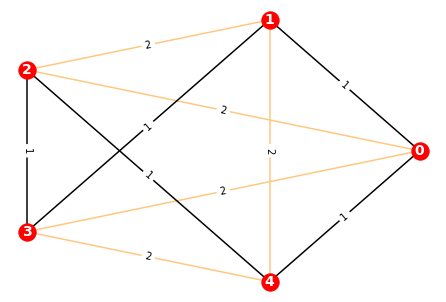

In [11]:
def twooptswap(G, i, j):
    '''Swap two vertices with each other and return new order as list'''
    route = G.vertices.copy()
    
    first = route[0:i] #get first part of cycle, before i
    mid = route[i:j] #get middle part of cycle
    rev = mid[::-1] #reverse middle part of cycle
    final = route[j:] #get final part of cycle
        
    #append middle (reversed) + final to first list to construct new cycle
    first.extend(rev)
    first.extend(final)
    
    #return new cycle
    return first
    
def twoopt(G):
    '''Keep swapping vertices until nodes exhausted or a shorter cycle is found'''
    shortest_cycle = G.vertices.copy() #store initial cycle
    shortest_distance = cost(G, shortest_cycle) #store distance of start cycle
    
    for i in range(len(shortest_cycle)): #for each vertex
        for j in range(len(shortest_cycle)): #for each vertex again
            if j <= i: #skip current (cannot swap with self) and previous vertices (already considered)
                continue
                
            cycle = twooptswap(G, i, j) #swap two nodes
            distance = cost(G, cycle) #calculate cost of new cycle
            
            #return new cycle/distance if shorter than previous
            if shortest_distance > distance:
                shortest_cycle = cycle
                shortest_distance = distance
                return shortest_cycle        
    
G = Graph(5,'easy')
show(G)
draw(G)
print('order: ', G.vertices)
print('Total Cost: ', cost(G, G.vertices.copy()))

5x5 easy graph:


,0,1,2,3,4
0,2,1,2,2,1
1,1,2,2,1,2
2,2,2,2,1,1
3,2,1,1,2,2
4,1,2,1,2,2


order:  [3, 2, 1, 0, 4]
Total Cost: 5


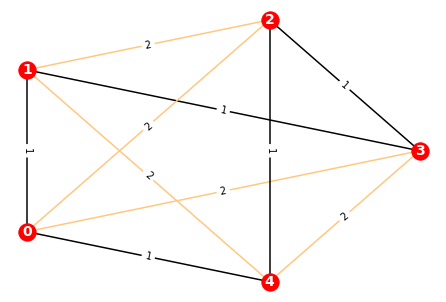

In [12]:
#copy the previous graph into a new object,
#perform two opt on new graph and draw
new_graph = copy.deepcopy(G)
new_cycle = twoopt(new_graph)
new_graph.vertices = new_cycle
show(new_graph)
draw(new_graph)
print('order: ', new_cycle)
print('Total Cost:' , cost(new_graph, new_cycle))



## Simulated Annealing 

### Introduction to Simulated Annealing
Simulated annealing, is an **approximation method to optimise a path from a search area.** Iteratively swaps neighbours to form new paths. If the new path cost is less than the current path cost, it accepts the new path and continues the iteration process. Otherwise, the algorithm runs an acceptance probability criterion function to see if the new (and worse) path will be accepted. The probability will depend on the temperature and the “height” between the new and current paths.
With each iteration, the temperature decreases until T(temperature) equals 0. The lower the temperature, the lower the probability of accepting a worse path. This is usually referred to as the annealing schedule (like the cooling schedule of annealing regarding heat treatment). The bigger the height (meaning the bigger the difference between the new and current path), the less likely the function is to accept the new path.

Simulated annealing accepts better results for each iteration to find an optimum (in this case, the smallest cost) but is also aware that it can reach the local optimum. **It will sometimes accept worse paths to investigate other local search areas and hopefully find the global optimum.**

### Algorithm: Simulated Annealing Pseudocode 
**Input:** A cycle of edges, with a weight when connecting to all other edges, an initial temperature, and a change determining the decrease in temperature over time.<br>**Output:** The smallest cost of the cycle and the cycle order.

1. $new\_solution \gets \text{current cycle from graph}$
2. $final\_solution \gets new\_solution$
3. $temperature \gets \text{temperature from input}$
4. $final\_temperature \gets \text{0}$
5. $temp\_decrement \gets \text{change from input}$
6. **while** $final\_temperature < temperature$ **do**
7. $\quad$ $\text{generate new neighbour for} new\_solution$
8. $\quad$ $cost_difference \gets new\_solution\_cost - final\_solution\_cost$
9. $\quad$ **if** $cost_difference < 0$ **then** 
10. $\qquad$ $final\_solution \gets new\_solution$
11. $\quad$ **else if** $rand(0,1) < exp(cost_difference / temperature)$ **then**
12. $\qquad$ $final\_solution \gets new\_solution$
13. $\quad$ **end if**
13. $\quad$ $temperature \gets temperature - temp\_decrement$
14. **end while**
15. **return** $final\_solution$

### Simulated Annealing: Big-O Analysis

The while loop will cost $O(n)$ while the rest of the algorithm is constant, so it can be assumed to cost $O(1)$. The total cost for the Simulated Annealing algorithm (in terms of time) costs $O(n)$.

### Implementation of Simulated Annealing

In [13]:
def simulatedAnnealing(G, initialTemperature, change):
    '''search for better cycles while periodically accepting worse cycles to explore
        as many local search areas to find the shortest cycle'''
    #solutions function like states(in this case, being a set order of the cycle)
    newSolution = G.vertices.copy() #also known as current state
    finalSolution = newSolution #plays the role as the shortest cycle
    temperature = initialTemperature
    finalTemperature = 0 #function stops once temperature reaches this number
    tempDecrement = change 
    
    while finalTemperature < temperature:
        newSolution = twooptAlt(G) #generate a new cycle via 2-opt local search method
        costDifference = (cost(G, newSolution) - cost(G, finalSolution))
        #print('cost difference: ', costDifference)
        #if the new cycle has a lower cost, accept as "final" solution,
        #otherwise test with acceptance criteron 
        if costDifference < 0:
            finalSolution = newSolution
            #print('Accepted!')
            #print('new solution: ', finalSolution)
            #print('new cost: ', cost(G, finalSolution))
        elif acceptanceProbability(costDifference, temperature):
            finalSolution = newSolution
            #print('Accepted!')
            #print('new solution: ', finalSolution)
            #print('new cost: ', cost(G, finalSolution))
        
        temperature -= tempDecrement #decrement temperature in accordance to annealing/cooling schedule
        
    return finalSolution

def acceptanceProbability(costDifference, temp):
    '''Acceptance probability criteron to decide whether to accept a worse cycle or not'''
    rnd = random.uniform(0,1)
    criterion = exp(-costDifference / temp)
    #print(rnd, ', ', critereon)
    if rnd < criterion:
        return True #accept cycle
    else:
        return False #reject cycle
    
def twooptAlt(G):
    '''Alternative version of 2-Opt method. Will return a new cycle regardless of the cost
        being smaller or not'''
    shortest_cycle = G.vertices.copy() #store initial cycle
    shortest_distance = cost(G, shortest_cycle) #store distance of start cycle
    
    i = random.randint(0, (len(G.vertices)-1))
    j = random.randint(0, (len(G.vertices)-1))

    new_cycle = twooptswap(G, i, j) #swap two nodes
    new_distance = cost(G, new_cycle) #calculate cost of new cycle

    shortest_cycle = new_cycle
    shortest_distance = new_distance
    return shortest_cycle

### Simulated Annealing: Time & Quality Experiments

10x10 symmetric graph:


,0,1,2,3,4,5,6,7,8,9
0,inf,2.0,62.0,99.0,85.0,41.0,79.0,50.0,32.0,86.0
1,2.0,inf,57.0,88.0,29.0,88.0,25.0,35.0,66.0,39.0
2,62.0,57.0,inf,7.0,34.0,52.0,59.0,22.0,61.0,85.0
3,99.0,88.0,7.0,inf,4.0,49.0,16.0,17.0,92.0,94.0
4,85.0,29.0,34.0,4.0,inf,39.0,64.0,37.0,2.0,58.0
5,41.0,88.0,52.0,49.0,39.0,inf,71.0,24.0,17.0,22.0
6,79.0,25.0,59.0,16.0,64.0,71.0,inf,65.0,13.0,67.0
7,50.0,35.0,22.0,17.0,37.0,24.0,65.0,inf,55.0,96.0
8,32.0,66.0,61.0,92.0,2.0,17.0,13.0,55.0,inf,29.0
9,86.0,39.0,85.0,94.0,58.0,22.0,67.0,96.0,29.0,inf


order:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total Cost:  329


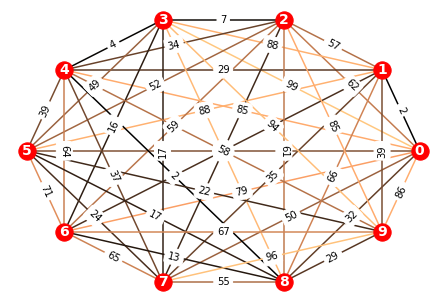

In [14]:
saGraph = Graph(10, 'symmetric')
show(saGraph)
draw(saGraph)
print('order: ', saGraph.vertices)
print('Total Cost: ', cost(saGraph, saGraph.vertices.copy()))

10x10 symmetric graph:


,0,1,2,3,4,5,6,7,8,9
0,inf,2.0,62.0,99.0,85.0,41.0,79.0,50.0,32.0,86.0
1,2.0,inf,57.0,88.0,29.0,88.0,25.0,35.0,66.0,39.0
2,62.0,57.0,inf,7.0,34.0,52.0,59.0,22.0,61.0,85.0
3,99.0,88.0,7.0,inf,4.0,49.0,16.0,17.0,92.0,94.0
4,85.0,29.0,34.0,4.0,inf,39.0,64.0,37.0,2.0,58.0
5,41.0,88.0,52.0,49.0,39.0,inf,71.0,24.0,17.0,22.0
6,79.0,25.0,59.0,16.0,64.0,71.0,inf,65.0,13.0,67.0
7,50.0,35.0,22.0,17.0,37.0,24.0,65.0,inf,55.0,96.0
8,32.0,66.0,61.0,92.0,2.0,17.0,13.0,55.0,inf,29.0
9,86.0,39.0,85.0,94.0,58.0,22.0,67.0,96.0,29.0,inf


order:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total Cost:  329


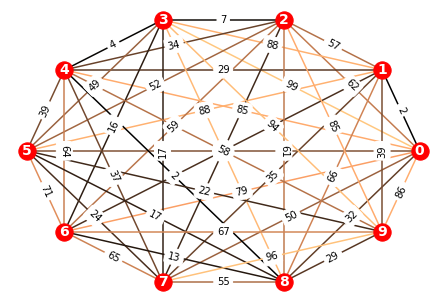

In [15]:
#demonstrating SA annealing to the graph above
newGraph = copy.deepcopy(saGraph)
newCycle = simulatedAnnealing(newGraph, 300, 1)
newGraph.vertices = newCycle
show(newGraph)
draw(newGraph)
print('order: ', newCycle)
print('Total Cost: ', cost(newGraph, newCycle))

#### Test Plan (Provisional)
The assignment brief advises students to use graphs "graphs with hundreds if not thousands of vertices" for measuring time and quality. Provisionally, it is proposed to generate graphs of each type (symmetric, asymettric and Euclidean) to test an equal number of graphs with hundreds and thousands of vertices, where the number of vertices are selected from the set: $n = \{300, 600, 900, 1200, 1500, 1800\}$.

In [16]:
def sa_stats(num_vertices, num_tests, graph_type='asymmetric'):
    '''Perform SA on graphs with a given number over vertices, a given number of times,
    and return (a) mean time elapsed and (b) mean reduction in cost'''
    
    # Initialise lists for calculating mean
    time_list = []
    cost_list = []
    
    # Loop that:
    # 1. Generates a graph of input type with input number of vertices
    # 2. Records cost of start cycle, and the current time before SA is performed
    # 3. Performs SA
    # 4. Records current time after SA is performed, and then record cost of new cycle
    # 5. Calculates elapsed time and difference in cost, and append these values to list
    for loop in range(num_tests):
        G = Graph(num_vertices, graph_type) # Generate graph of type
        old_cycle = G.vertices.copy() # Copy initial cycle
        start_cost = cost(G, old_cycle) # Record cost at start
        before_sa = perf_counter() # Record time immediately before SA
        new_cycle = simulatedAnnealing(G, 300, 1) # Perform SA
        after_sa = perf_counter() # Record time immediately after SA
        end_cost = cost(G, new_cycle) # Record cost of newly found cycle
        elapsed = after_sa - before_sa # Calculate time SA function has taken in seconds
        time_list.append(elapsed) # Append elapsed time to list
        cost_difference = (start_cost - end_cost) / start_cost # Calculate difference in cost
        cost_list.append(cost_difference) # Append cost difference to list
    
    return time_list, cost_list

In [17]:
# BE CAREFUL. THIS TAKES A VERY LONG TIME TO PROCESS WITH OUR TEST CASES

def createTestData(graph_list, max_reps, graph_type='asymmetric'):
    '''Given an array of edge lengths (integer) and the number of test repititions, returns a table 
        containing computation time and difference in cost (before and after) for each edge length'''
    i = 0
    data_table = pd.DataFrame(columns=['edge count (n)', 'Time (seconds)', 'Reduced by (%)'])
    for graph_number in graph_list:
        graph_time_list, graph_cost_list = sa_stats(graph_number, max_reps, graph_type) #generates stats for test
        for j in range(0, max_reps): #adds data to table
            data_table.loc[i] = [graph_number, graph_time_list[j], graph_cost_list[j]]
            i += 1
    #calculates min, max, mean value and standard deviation for each set of data
    return data_table.groupby('edge count (n)').agg(['min','max','mean','std'])

In [18]:
#createTestData([300,600,900,1200,1500,1800],200) # Produce stats table for asymmetric graphs

In [19]:
#createTestData([300,600,900,1200,1500,1800],200, 'symmetric') # Produce stats table for symmetric graphs

In [20]:
#createTestData([300,600,900,1200,1500,1800],200, 'Euclidean') # Produce stats table for Euclidean graphs

# Genetic Algorithm

Genetic Algorithm is a metaheuristic that is inspired of natural evolution by Charles Darwin’s. This algorithm mirrors the process of natural selection where the fittest individuals (in this case the fastest individuals from the search) are selected for reproduction to produce offspring of the next generation.  

## The Notion of Natural Selection 

Natural selection starts with the survival of the fittest from a population. They then go on to produce offspring which inherit the characteristics of the parents and is added upon to the next generation. If parents possess desirable characteristics to survive, the parent’s offspring will have a better chance at surviving. This process continually iterates and at the end, a generation with the fittest individuals will be presented. (Thengade and Donda, 2012l) 

This notion can be applied for a search problem. We consider a set of solutions for a problem and select the set of best ones out of them. (Tabassum and Mathew, 2014)

Five phases are considered in a genetic algorithm. 

    1.Initial population 
    2.Fitness function 
    3.Selection 
    4.Crossover 
    5.Mutation 

#### Genetic Algorithm Pseudocode

The algorithm takes parameters for population size ($P$) and generation count ($G$).
 
1. $population \gets \text{P random permutations of vertices}$
2. $generation\_count \gets 0$
3. **while** $generation\_count < G$ **do**
4. $\quad$ $population \gets \text{population ranked and sorted by fitness}$
5. $\quad$ $selection \gets \text{indexes of individuals chosed for breeding}$
6. $\quad$ $children \gets \text{children of selected breeding pool}$
7. $\quad$ $children \gets \text{Apply mutation}$
8. $\quad$ $population \gets children$
9. **end while**
10. return $population$

### Complexity Analysis

1. n
2. 1
3. 1
4. n + logn
5. n
6. n
7. n
8. 1
9. 1
10. 1

The algorithm has a time complexity of $O(nlog(n))$. However, the algorithm scales with its other parameters, such as population size which scales by an order of $O(n^2)$ and generation count which scales linearly ($O(n)$)

## Initial Population

The process begins with a random initial population of P chromosomes (cycles). The chromosomes are made up of N+1 genes (to satisfy the constraint that the cycle must start and end at the same node) which represent the nodes of the graph. 



In [21]:
def getInitialPop(G, popSize):
	#Create a random population (list) of individuals (routes)

	pop = []

	#We need routes that start and end at 0 so we fix them to the start and end
	verts = G.vertices.copy()
	verts.remove(0)
	for i in range(popSize):
		pop.append([0] + list(np.random.permutation(verts)) + [0])
	
	return pop

## Fitness Function

The fitness function is given as a score to each individual, the fitness score is used as a basis for the probability for the specific probability for reproduction. In this implementation, the fitness score is defined as 1 / dist(Route). 

### Elitism: 
Elitism is used to ensure that the fitness of the population does not regress. A small number of the fittest routes are selected and automatically brought forwards into the next generation unchanged.




In [22]:
def determineFitnessAndRank(G, pop):

	#Creates dictionary of {Route Index: Fitness Score} 
	#Fitness score = reciprocal of route length
	fitnessResults = {}
	for i in range(0, len(pop)):
		fitnessResults[i] = (1 / cost(G, pop[i]))

	#Sorts the route indicies by fitness score
	popRanked = sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

	return popRanked #array of tuples (index, score)

## Selection

Individuals are selected for breeding via fitness proportionate selection (also known as roulette wheel selection). In this method, the probability that a chromosome is selected is proportional to its fitness score. This causes the overall fitness of the selected population to trend upwards. Elite individuals are automatically selected, while the remainder of the mating pool is filled used the above method to select candidates. This method allows for duplicate candidates to be added to the pool. This can be counterproductive, as high-quality individuals can dominate the mating pool and reduce diversity, causing the algorithm to converge too early on a local optimum. 



In [23]:
def selection(popRanked, eliteSize):

	#Start selecting which individuals (routes) will breed
	#Use Elitisim (The fittest routes will automatically be added to the breeding pool)
	selectionResults = []

	#Put index/fitness dict into dataframe
	df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])

	#Record the cumulative fitness score as you move down the table
	df['cum_sum'] = df.Fitness.cumsum()

	#Also record this as a cumulative percentage
	df['cum_perc'] = 100*(df.Fitness.cumsum()/df.Fitness.sum())

	for i in range(0, eliteSize):
		#Add our n number of elite routes
		selectionResults.append(popRanked[i][0])
	
	#Weighted roulette selections
	max = df['cum_sum'].iloc[-1]
	for i in range(len(popRanked) - eliteSize):
		pick = random.uniform(0, max)
		current = max
		for chromosome in popRanked:
			current -= chromosome[1]
			if current < pick:
				selectionResults.append(chromosome[0])
				break
	
	return selectionResults #An array of which indexes (from the original unsorted population) will be selected for mating

def getMatingPool(pop, selectionResults):
	#Fill our mating pool
	matingPool = []
	for i in range(0, len(selectionResults)):
		ind = selectionResults[i]
		matingPool.append(pop[ind])

	return matingPool

## Crossover

The algorithm uses Cycle Crossover (CX) to ‘breed’ two parent chromosomes and create two new child chromosomes. This crossover method works as follows: 

    1. Chooses the first index in parent 1 that is not already included in a cycle. 
    2. Include this index in the current cycle. 
    3. Selects the gene at this index at parent 2. 
    4. Finds the index of this gene in parent 1. 
    5. If this index is already in the current cycle, go to step 1. Else, go to step 2. 
    6. Terminate when each index is mapped to a cycle. 

Once the cycles have been identified, the children inherit the cycles of both parents. Child 1 inherits the even cycles from the first parent and the odd cycles from the second parent, and vice versa for child 2.

![Cycle Crossover](cycle-crossover.png)
(Lukas et al, 2012)

This method preserves our conditions that the solutions must be cycles (as in, they must start and end at the same node). As all solutions start and end with node 0, the start and end of the parents will always be identified as a cycle and the subsequent children will always inherit this cycle. 

Our algorithm uses a 0.85 default crossover rate, which means that some chromosomes sometimes do not breed and instead carry themselves forward into the next generation. If the crossover rate is very high, the chromosomes in the population will change often, resulting in high diversity (and a better chance of achieving a global optimum), but slow convergence. If the rate is too low, the algorithm will converge quickly but will likely not have explored enough solutions to find a global optimum. 

Crossover operations are useful for converging on a solution but become less effective as the population becomes less diverse. Therefore, mutation is required to sometimes “knock” the solutions into other neighbourhoods where a better solution than the current optimum may be found. 

In [24]:
def breed(parent1, parent2):
	#Cycle Crossover method
	#Uses a lookup table to reduce runtime (list.locate() is O(n), lookup is (O(1)))
	#Preserves the start and end nodes (Good choice for our constraints)
	lookup1 = lookup2 = {}
	for i in range(len(parent1)):
		lookup1[parent1[i]] = i
	for i in range(len(parent2)):
		lookup2[parent2[i]] = i

	cycles = [-1 for i in range(len(parent1))]
	cycleNumber = 1
	cycleStart = (i for index, value in enumerate(cycles) if value < 0)

	for position in cycleStart:
		while cycles[position] < 0:
			cycles[position] = cycleNumber
			position = lookup1[parent2[position]]
		cycleNumber += 1
	
	child1 = [parent1[i] if n%2 else parent2[i] for i, n in enumerate(cycles)]
	child2 = [parent2[i] if n%2 else parent1[i] for i, n in enumerate(cycles)]

	return child1, child2

def breedPop(matingPool, eliteSize, crossoverRate):
	#Creates a new population from the mating pool
	children = []
	length = len(matingPool) - eliteSize

	#Automatically bring the elites into the next generation
	#This ensures that future generations can only improve/never regress
	for i in range(0, eliteSize):
		children.append(matingPool[i])
	
	#Breed the mating pool and add to the next generation
	for i in range(0, length-1, 2):
		if random.random() < crossoverRate:
			child1, child2 = breed(matingPool[i], matingPool[i+1])
			children.append(child1)
			children.append(child2)
		else:
			children.append(matingPool[i])
			children.append(matingPool[i+1])
	
	return children

## Mutation

To increase the exploration of potential solutions, all chromosomes in the population (excluding the elites) have a chance to randomly mutate. In this instance, mutation means that a sequence of genes in the chromosome will be reversed. 

In [25]:
def mutate(route):
	#Reverses a random length section of the route
	#The start and end nodes cannot be selected as part of this section
	i, j = sorted(random.sample(range(1, len(route)-1), 2))
	route[i:j] = route[j-1:i-1:-1]
	
def mutatePop(population, mutationRate, eliteSize):
	#Iterates over an entire population and applies mutation
	mutatedPop = []

	for i in range(0, eliteSize):
		mutatedPop.append(population[i])
	
	for i in range(eliteSize, len(population)-1):
		if random.random() < mutationRate:
			mutate(population[i]) #Mutate in place
		mutatedPop.append(population[i])
	
	return mutatedPop

## Generations

After mutation, the population is once again ranked by its fitness and the process repeats again for a number of generations (G). 

In [26]:
def nextGeneration(G, currentGen, eliteSize, mutationRate, crossoverRate):
	'''
	1. Determine fitness (route lengths)
	2. Select mating pool (choose subset of routes)
	3. Breed (merge pairs of routes to create new routes)
	4. Repeat
	'''
	rankedPop = determineFitnessAndRank(G, currentGen)
	selectionResults = selection(rankedPop, eliteSize)
	matingPool = getMatingPool(currentGen, selectionResults)
	children = breedPop(matingPool, eliteSize, crossoverRate)
	nextGen = mutatePop(children, mutationRate, eliteSize)

	return nextGen

def GeneticAlgorithm(G, popSize = 300, mutationRate = 0.3, crossoverRate = 0.85, generations = 500):
	#Get initial population and best distance
	if popSize*0.05 < 1: 
		eliteSize = 1
	else:
		eliteSize = int(popSize*0.05)
	pop = getInitialPop(G, popSize)
	initialDistance = 1 / determineFitnessAndRank(G, pop)[0][1]
	distanceHistory = {}

	#Apply the algorithm
	for i in range(0, generations):
		pop = nextGeneration(G, pop, eliteSize, mutationRate, crossoverRate)
		distanceHistory[i] = (1 / determineFitnessAndRank(G, pop)[0][1])
	
	#Get our new best distance and route
	bestDistance = 1 / determineFitnessAndRank(G, pop)[0][1]
	improvementPerc = (1 - (bestDistance/initialDistance))*100
	bestRouteIndex = determineFitnessAndRank(G, pop)[0][0]
	bestRoute = pop[bestRouteIndex]

	return (bestRoute, bestDistance, distanceHistory)

# Genetic Algorithm - Testing

The following parameters are defined as default and are used except where one variable is chosen to be independent:

$population\_size = 500$  
$generation\_count = 500$  
$mutation\_rate = 0.6$  
$crossover\_rate = 0.8$  
  
$graph\_type = $text{symmetric}  
$graph\_size = 100$  

In [27]:
def testAgainstGreedy(repetitions = 10, n = 100, graphType = "symmetric", popSize = 500, mutationRate = 0.6, crossoverRate = 0.8, generations = 500):
	data = pd.DataFrame(columns=['graph size', 'population size', 'mutation rate', 'crossover rate', 'generations', 'greedy cost', 'greedy time', 'genetic cost', 'genetic time', 'quality'])
	i = 0
	
	for _ in range(repetitions):
		myG = Graph(n, graphType)
		t0 = perf_counter()
		geneticRoute, geneticCost, distanceHistory = GeneticAlgorithm(myG, popSize, mutationRate, crossoverRate, generations)
		t1 = perf_counter()
		geneticTime = t1 - t0
		t0 = perf_counter()
		greedyRoute, greedyCost = greedy_nearest_neighbour(myG)
		t1 = perf_counter()
		greedyTime = t1 - t0
		data.loc[i] = [n, popSize, mutationRate, crossoverRate, generations, greedyCost, greedyTime, geneticCost, geneticTime, 1 / (geneticCost/greedyCost)]
		i += 1
	
	return data

## Graph Size

The graph below illustrate how the time taken and quality (when compared to the Greedy Nearest Neighbour solution) of generated solutions vary as a function of graph size. The time taken as graph size increases seems to be in line with our earlier assertion that the algorithm has a time complexity of $O(nlog(n))$.

The quality of the graph decreases sharply with graph size. This can be explained by the number of possible solutions being ${n!} and therefore the algorithm does not have enough time to find a high quality solution. This could be fixed by allowing the default parameters of the algorithm to adapt to the graph specification, although this would have further implications on the running time.

In [28]:
frames = [testAgainstGreedy(n = n) for n in range(10, 351, 50)]
concatenatedFrames = pd.concat(frames)
concatenatedFrames.groupby('graph size').agg(['mean', 'std'])[['greedy time', 'genetic time', 'greedy cost', 'genetic cost', 'quality']]

greedy time               genetic time           greedy cost  \
                  mean           std         mean       std        mean   
graph size                                                                
10.0          0.000032  8.651057e-07     4.324723  0.154559       233.5   
60.0          0.000428  1.187068e-05     8.122508  0.997386       454.3   
110.0         0.001808  6.410105e-04    12.110736  2.343901       570.6   
160.0         0.003139  1.254503e-03    14.075296  0.447156       619.2   
210.0         0.005317  1.798410e-03    16.545822  1.267392       686.1   
260.0         0.009536  3.802212e-03    20.826414  3.012662       725.3   
310.0         0.010351  1.223620e-03    25.981016  0.429225       791.7   

                      genetic cost               quality            
                  std         mean         std      mean       std  
graph size                                                          
10.0        85.881378        183.8   49.492536  1.263759  0.354963  
60.0        62.592243        547.4   26.222128  0.829621  0.106567  
110.0       68.684787       1423.2   68.504339  0.401882  0.052262  
160.0       80.391818       2609.7   87.479585  0.238150  0.036702  
210.0       79.164316       4034.2  130.193702  0.170465  0.022275  
260.0       55.653791       5609.9  144.456414  0.129389  0.010913  
310.0       80.415656       7430.4  225.127223  0.106545  0.010384

Text(0, 0.5, 'Quality')

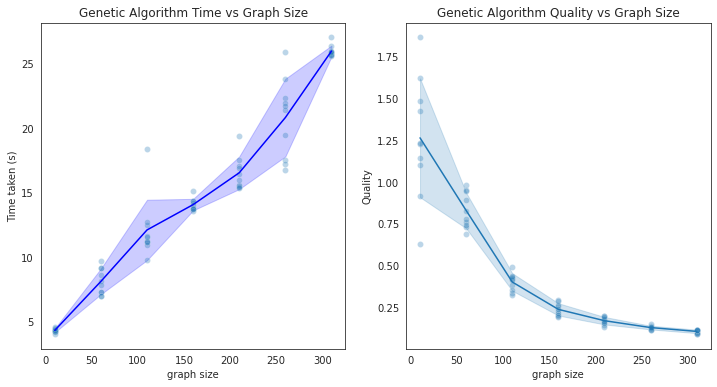

In [29]:

#Graphs are plotted below
fig, (time, quality) = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.lineplot(data = concatenatedFrames, x = 'graph size', y = 'genetic time', ci = 'sd', color='blue',ax=time)
sns.scatterplot(data = concatenatedFrames, x = 'graph size', y = 'genetic time', alpha = 0.3, ax=time)
sns.lineplot(data = concatenatedFrames, x = 'graph size', y = 'quality', ci='sd', ax=quality)
sns.scatterplot(data = concatenatedFrames, x = 'graph size', y = 'quality', alpha = 0.3, ax=quality)

time.title.set_text('Genetic Algorithm Time vs Graph Size')
quality.title.set_text('Genetic Algorithm Quality vs Graph Size')
time.set_ylabel('Time taken (s)')
quality.set_ylabel('Quality')

## Population Size

The running time of the algorithm increases polynomially with population size, as we previously established. This is because the selection method scales with population size by a factor of $P^2$. However, we can see that quality incrases linearly with population size, as a larger population allows the algorithm to explore more potential solutions per iteration and thus find a more suitable solution than it would with a smaller search scope.

In [30]:
frames = [testAgainstGreedy(popSize= n) for n in range(100, 1001, 200)]
concatenatedFrames = pd.concat(frames)
concatenatedFrames.groupby('population size').agg(['mean', 'std'])[['greedy time', 'genetic time', 'greedy cost', 'genetic cost', 'quality']]

greedy time           genetic time           greedy cost  \
                       mean       std         mean       std        mean   
population size                                                            
100.0              0.001383  0.000444     2.152947  0.031098       500.8   
300.0              0.001341  0.000422     5.270211  0.316874       498.5   
500.0              0.001298  0.000417    11.669741  0.336975       511.9   
700.0              0.002187  0.002033    22.463731  0.334624       484.0   
900.0              0.001304  0.000391    38.639018  3.478739       504.8   

                           genetic cost               quality            
                       std         mean         std      mean       std  
population size                                                          
100.0            52.526819       3071.4  151.262245  0.163453  0.019355  
300.0            49.610147       1756.6   67.807243  0.284258  0.031835  
500.0            38.914293       1242.3   93.459498  0.414253  0.044614  
700.0            44.574532        938.6   56.950661  0.515711  0.036578  
900.0            53.596849        797.6   51.390012  0.633853  0.067528

Text(0, 0.5, 'Quality')

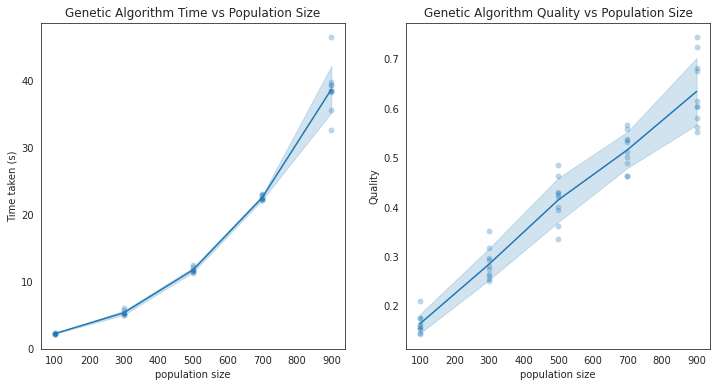

In [31]:
#Graphs are plotted below
fig, (time, quality) = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.lineplot(data = concatenatedFrames, x = 'population size', y = 'genetic time', ci = 'sd',ax=time)
sns.scatterplot(data = concatenatedFrames, x = 'population size', y = 'genetic time', alpha = 0.3, ax=time)
sns.lineplot(data = concatenatedFrames, x = 'population size', y = 'quality', ci='sd', ax=quality)
sns.scatterplot(data = concatenatedFrames, x = 'population size', y = 'quality', alpha = 0.3, ax=quality)

time.title.set_text('Genetic Algorithm Time vs Population Size')
quality.title.set_text('Genetic Algorithm Quality vs Population Size')
time.set_ylabel('Time taken (s)')
quality.set_ylabel('Quality')

## Crossover Rate

The graphs for crossover rate show that, in general, quality increases with crossover rate. A high crossover rate increases diversity within the population, but a crossover rate that is too high will introduce too much randomness and will prevent the algorithm from converging on a solution. 

In [32]:
frames = [testAgainstGreedy(crossoverRate= n/10) for n in range(1, 10, 1)]
concatenatedFrames = pd.concat(frames)
concatenatedFrames.groupby('crossover rate').agg(['mean', 'std'])[['greedy time', 'genetic time', 'greedy cost', 'genetic cost', 'quality']]

greedy time           genetic time           greedy cost  \
                      mean       std         mean       std        mean   
crossover rate                                                            
0.1               0.001337  0.000497     9.696270  2.038480       528.6   
0.2               0.001296  0.000437     8.807225  0.707115       521.4   
0.3               0.001149  0.000318     8.610236  0.370139       522.9   
0.4               0.001075  0.000061     8.433556  0.428969       515.1   
0.5               0.001178  0.000319     8.900172  0.330202       553.8   
0.6               0.001885  0.000778    12.228637  2.132152       541.6   
0.7               0.001603  0.000726    13.362633  0.998547       519.4   
0.8               0.001229  0.000463     9.860304  1.413877       539.9   
0.9               0.001154  0.000274    10.241359  0.390279       501.5   

                          genetic cost               quality            
                      std         mean         std      mean       std  
crossover rate                                                          
0.1             28.300766       3545.2  228.124138  0.149679  0.012990  
0.2             69.709237       2778.8  125.377474  0.188035  0.026658  
0.3             59.060139       2215.0   94.692485  0.236596  0.029629  
0.4             46.862565       1799.8   95.569405  0.286386  0.023385  
0.5             69.864631       1551.2   85.068339  0.357324  0.041705  
0.6             56.257740       1399.6   74.214704  0.386797  0.032503  
0.7             70.911839       1320.9   45.278030  0.393648  0.055049  
0.8             60.098900       1212.4   52.749302  0.446453  0.056446  
0.9             72.259179       1193.1  117.331866  0.422137  0.058399

Text(0, 0.5, 'Quality')

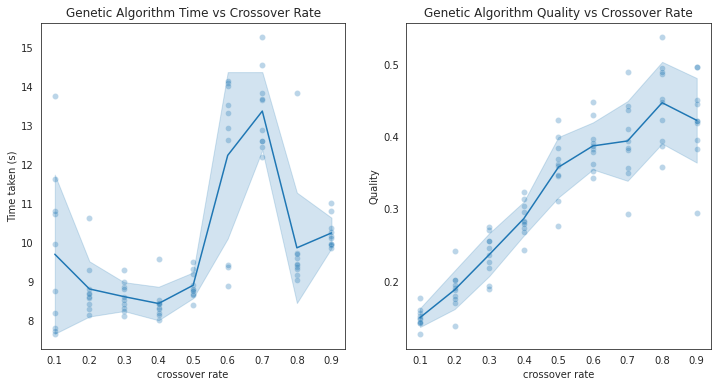

In [33]:
#Graphs are plotted below
fig, (time, quality) = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.lineplot(data = concatenatedFrames, x = 'crossover rate', y = 'genetic time', ci = 'sd',ax=time)
sns.scatterplot(data = concatenatedFrames, x = 'crossover rate', y = 'genetic time', alpha = 0.3, ax=time)
sns.lineplot(data = concatenatedFrames, x = 'crossover rate', y = 'quality', ci='sd', ax=quality)
sns.scatterplot(data = concatenatedFrames, x = 'crossover rate', y = 'quality', alpha = 0.3, ax=quality)

time.title.set_text('Genetic Algorithm Time vs Crossover Rate')
quality.title.set_text('Genetic Algorithm Quality vs Crossover Rate')
time.set_ylabel('Time taken (s)')
quality.set_ylabel('Quality')

## Mutation Rate

Mutation rate has a smaller effect on the quality or speed of the algorithm and only serves to prevent the algorithm from becoming stuck at a local optimum. We can see that the best quality is achieved when mutation rate is not very small or very large.

In [34]:
frames = [testAgainstGreedy(mutationRate= n/10) for n in range(1, 10, 1)]
concatenatedFrames = pd.concat(frames)
concatenatedFrames.groupby('mutation rate').agg(['mean', 'std'])[['greedy time', 'genetic time', 'greedy cost', 'genetic cost', 'quality']]

greedy time           genetic time           greedy cost  \
                     mean       std         mean       std        mean   
mutation rate                                                            
0.1              0.001059  0.000022     9.198320  0.504388       524.2   
0.2              0.001071  0.000061     8.922315  0.285836       508.9   
0.3              0.001065  0.000020     8.920135  0.095534       540.9   
0.4              0.001058  0.000010     8.974764  0.175499       513.6   
0.5              0.001065  0.000043     9.019143  0.237689       508.2   
0.6              0.001124  0.000253     9.133127  0.353917       485.4   
0.7              0.001076  0.000039     9.057274  0.153263       496.2   
0.8              0.001054  0.000019     9.123388  0.171613       538.5   
0.9              0.001106  0.000222     9.120564  0.125548       505.6   

                         genetic cost               quality            
                     std         mean         std      mean       std  
mutation rate                                                          
0.1            57.332946       1596.9  107.927393  0.329841  0.044763  
0.2            74.434834       1393.0  101.134674  0.368236  0.066866  
0.3            72.054686       1278.5   74.103906  0.425204  0.068018  
0.4            69.263105       1251.2   77.121549  0.412573  0.067684  
0.5            48.830318       1206.2   88.906693  0.422750  0.046698  
0.6            60.063300       1222.1   48.580860  0.397443  0.049021  
0.7            52.870492       1227.1   48.571711  0.405535  0.052042  
0.8            55.047959       1292.1   93.521774  0.418764  0.051520  
0.9            82.300533       1406.0   78.666667  0.361032  0.066023

Text(0, 0.5, 'Quality')

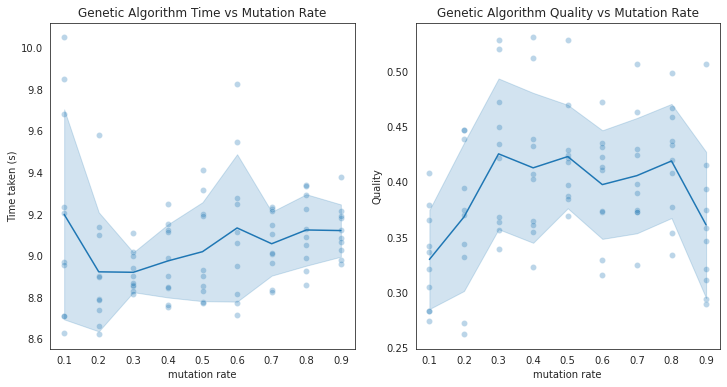

In [35]:
#Graphs are plotted below
fig, (time, quality) = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.lineplot(data = concatenatedFrames, x = 'mutation rate', y = 'genetic time', ci = 'sd',ax=time)
sns.scatterplot(data = concatenatedFrames, x = 'mutation rate', y = 'genetic time', alpha = 0.3, ax=time)
sns.lineplot(data = concatenatedFrames, x = 'mutation rate', y = 'quality', ci='sd', ax=quality)
sns.scatterplot(data = concatenatedFrames, x = 'mutation rate', y = 'quality', alpha = 0.3, ax=quality)

time.title.set_text('Genetic Algorithm Time vs Mutation Rate')
quality.title.set_text('Genetic Algorithm Quality vs Mutation Rate')
time.set_ylabel('Time taken (s)')
quality.set_ylabel('Quality')

## Generation Count

The time taken against varying generation counts conforms to our earlier asserting that the algorithm scales linearly with this parameter. In practice, however, we can see that the time taken for the first 300 generation is slower on average compared to later generations. This is a problem that exists in practice because the solution improves drastically over the first 300 generations, meaning that more computations are made compared to the later generations where only small changes may occur over a long time.

This is also supported by the quality graph increasing sharply for the first 300 generations, after whichafter which it begins to decline (possibly due to mutation/crossover causing less optimal soltuions to be carried over between generations)

In [36]:
frames = [testAgainstGreedy(generations = n) for n in range(100, 1001, 200)]
concatenatedFrames = pd.concat(frames)
concatenatedFrames.groupby('generations').agg(['mean', 'std'])[['greedy time', 'genetic time', 'greedy cost', 'genetic cost', 'quality']]

greedy time           genetic time           greedy cost  \
                   mean       std         mean       std        mean   
generations                                                            
100.0          0.001024  0.000025     5.516281  0.204536       547.8   
300.0          0.001157  0.000319     8.309849  0.163341       563.3   
500.0          0.001091  0.000113     9.050305  0.181723       532.6   
700.0          0.001165  0.000323     9.769778  0.204245       527.8   
900.0          0.001046  0.000018    10.456155  0.292865       496.3   

                       genetic cost               quality            
                   std         mean         std      mean       std  
generations                                                          
100.0        64.477042       1895.6  128.478446  0.289453  0.032617  
300.0        85.855240       1191.3   79.673012  0.470884  0.043038  
500.0        59.402955       1191.6   83.397575  0.448399  0.056261  
700.0        59.040099       1223.3   96.522939  0.433165  0.053989  
900.0        56.071482       1228.2   90.594089  0.405188  0.044898

Text(0, 0.5, 'Quality')

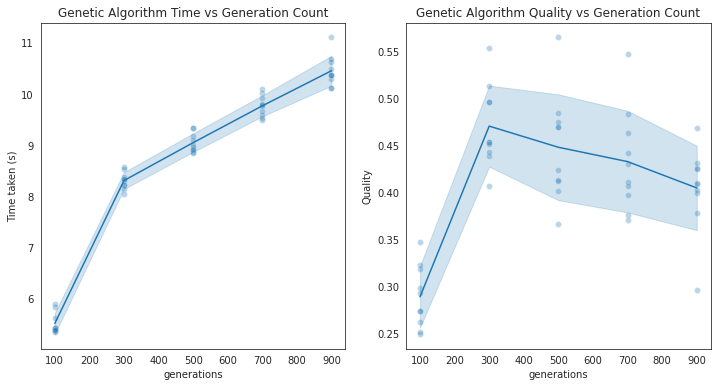

In [37]:

#Graphs are plotted below
fig, (time, quality) = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.lineplot(data = concatenatedFrames, x = 'generations', y = 'genetic time', ci = 'sd',ax=time)
sns.scatterplot(data = concatenatedFrames, x = 'generations', y = 'genetic time', alpha = 0.3, ax=time)
sns.lineplot(data = concatenatedFrames, x = 'generations', y = 'quality', ci='sd', ax=quality)
sns.scatterplot(data = concatenatedFrames, x = 'generations', y = 'quality', alpha = 0.3, ax=quality)

time.title.set_text('Genetic Algorithm Time vs Generation Count')
quality.title.set_text('Genetic Algorithm Quality vs Generation Count')
time.set_ylabel('Time taken (s)')
quality.set_ylabel('Quality')

## Graph Type

Against the varying graph types, the genetic algorithm performs best with symmetric graphs. This is most likely due to that fact that symmetric graphs have half as many possibly solutions as asymmetric graphs, therefore meaning that an optimal solution should only take half as long to find.

In [38]:
symmetricData = testAgainstGreedy()
symmetricData['graph type'] = 'symmetric'

asymmetricData = testAgainstGreedy(graphType='asymmetric')
asymmetricData['graph type'] = 'asymmetric'

euclideanData = testAgainstGreedy(graphType='euclidean')
euclideanData['graph type'] = 'euclidean'

cyclicData = testAgainstGreedy(graphType='easy')
cyclicData['graph type'] = 'cycle'

concatenatedFrames = pd.concat([symmetricData, asymmetricData, euclideanData, cyclicData])
concatenatedFrames.groupby('graph type').agg(['mean', 'std'])[['greedy time', 'genetic time', 'greedy cost', 'genetic cost', 'quality']]

greedy time           genetic time           greedy cost  \
                  mean       std         mean       std        mean   
graph type                                                            
asymmetric    0.001529  0.000699    11.357841  1.768074       514.2   
cycle         0.001434  0.000439    11.520092  0.754105       100.0   
euclidean     0.001733  0.000645    13.048389  2.871589       575.9   
symmetric     0.001258  0.000498     9.484464  0.405994       506.9   

                      genetic cost               quality            
                  std         mean         std      mean       std  
graph type                                                          
asymmetric  54.586934       2521.5  106.286040  0.204076  0.020985  
cycle        0.000000        148.7    1.702939  0.672574  0.007686  
euclidean   95.762960       2543.8  153.601071  0.226307  0.034693  
symmetric   50.573269       1194.9   44.033952  0.425646  0.053825

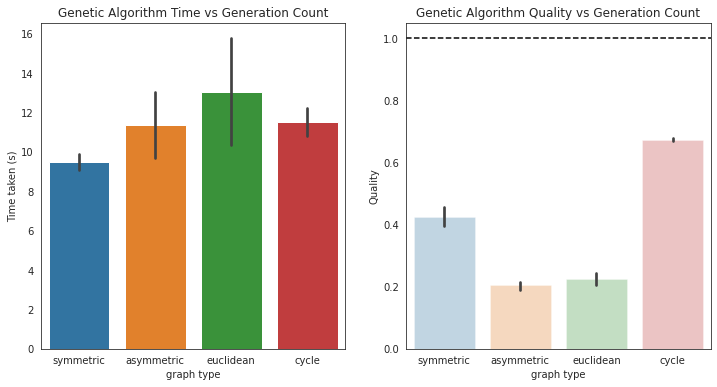

In [39]:
#Graphs are plotted below
fig, (time, quality) = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.barplot(data = concatenatedFrames, x = 'graph type', y = 'genetic time', ci = 'sd',ax=time)
sns.barplot(data = concatenatedFrames, x = 'graph type', y = 'quality', alpha = 0.3, ax=quality)

time.title.set_text('Genetic Algorithm Time vs Generation Count')
quality.title.set_text('Genetic Algorithm Quality vs Generation Count')
time.set_ylabel('Time taken (s)')
quality.set_ylabel('Quality')
quality.axhline(y=1, color='black', ls='--')

# Genetic Algorithm Analysis

The algorithm has been shown to be effective for small ($n < 50$), symmetric graphs due to the small pool of possible solutions. When the number of possibilities increases, the quality of the generated solution is significantly worse than the Greedy Nearest Neighbour solution. While some of this quality can be recovered by increasing parameter values ($P, G$), this causes a drastic increase in time taken and therefore makes this particular implementation ineffective for large sizes of $n$. This may be due to the particular choice of selection, breeding or mutation function as these (as well as their associated parameters) have been shown to have an impact on the efficacy of the algorithm (Vasconcelos, 2001).

## References

- https://www.researchgate.net/publication/6026283_Optimization_by_Simulated_Annealing
- Croes, G. (1958). A Method for Solving Traveling-Salesman Problems. Operations Research, 6(6), 791-812. Retrieved March 25, 2021, from http://www.jstor.org/stable/167074
- Sathyan, A., Boone, N. and Cohen, C. (2015).Comparison of Approximate Approaches to Solving the Travelling Salesman Problem and its Application to UAV Swarming. Retrieved March 25 2021, from https://www.researchgate.net/publication/268981882_Comparison_of_Approximate_Approaches_to_Solving_the_Travelling_Salesman_Problem_and_its_Application_to_UAV_Swarming **(page 6)**
- Samuel Lukas, A. Aribowo, Milyandreana Muchri (2012). Solving Timetable Problem by Genetic Algorithm and Heuristic Search Case Study: Universitas Pelita Harapan Timetable
- J. A. Vasconcelos, J. A. Ramírez, R. H. C. Takahashi, and R. R. Saldanha (2001). Improvements in Genetic Algorithms